### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['PYTHONWARNINGS'] = 'ignore'

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
data = pd.read_csv('Data/cleaned_data.csv')

In [4]:
data.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
data = data.drop(['created_date'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238964 entries, 0 to 238963
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   city_tier               238964 non-null  float64
 1   first_platform_c        238964 non-null  object 
 2   first_utm_medium_c      238964 non-null  object 
 3   first_utm_source_c      238964 non-null  object 
 4   total_leads_droppped    238964 non-null  float64
 5   referred_lead           238964 non-null  float64
 6   app_complete_flag       238964 non-null  int64  
 7   assistance_interaction  238964 non-null  float64
 8   career_interaction      238964 non-null  float64
 9   payment_interaction     238964 non-null  float64
 10  social_interaction      238964 non-null  float64
 11  syllabus_interaction    238964 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 21.9+ MB


### 3 Setting up Environment: 

In [7]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

In [8]:
import os
import sqlite3

# Get current directory (where notebook is running)
db_dir = os.getcwd()  # this will be '02_training_pipeline/notebooks' if running from the notebook

# Define DB name and full path
db_name = 'lead_scoring_model_experimentation.db'
db_path = os.path.join(db_dir, db_name)

# Create a connection to the SQLite database
conn = sqlite3.connect(db_path)

# Print confirmation
print(f"Database created at: {db_path}")

# Close connection
conn.close()

Database created at: /home/upgrad-codepro/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db



Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 

mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0


mlflow server \
  --backend-store-uri='sqlite:////home/upgrad-codepro/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' \
  --default-artifact-root="./mlruns" \
  --port=6006 \
  --host=0.0.0.0

In [9]:
import mlflow
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [10]:
from pycaret.classification import *

exp = setup(
    data=data,
    target = 'app_complete_flag',  
    fold_shuffle=True, 
    session_id = 42,
    normalize = True, 
    transformation = True, 
    remove_multicollinearity = True, 
    multicollinearity_threshold = 0.95,
    n_jobs=4,
    use_gpu=False,
    log_experiment=True,
    experiment_name='Lead_Scoring_Model_Experimentation',
    log_plots=True,
    log_data=True,
    verbose=True,
    log_profile=False,
    silent=True
)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [11]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(sort='AUC', exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7385,0.8211,0.8301,0.7033,0.7614,0.4764,0.4844,2.4790
lightgbm,Light Gradient Boosting Machine,0.7384,0.8211,0.8334,0.7020,0.7621,0.4762,0.4849,0.2070
rf,Random Forest Classifier,0.7369,0.8188,0.8234,0.7038,0.7589,0.4734,0.4805,0.7840
et,Extra Trees Classifier,0.7366,0.8179,0.8206,0.7043,0.7580,0.4726,0.4793,0.9340
dt,Decision Tree Classifier,0.7363,0.8171,0.8202,0.7042,0.7577,0.4721,0.4788,0.1460
lr,Logistic Regression,0.7168,0.7917,0.8019,0.6871,0.7401,0.4330,0.4393,0.8920
lda,Linear Discriminant Analysis,0.7150,0.7904,0.8134,0.6815,0.7416,0.4294,0.4378,0.2330
nb,Naive Bayes,0.6779,0.7383,0.8540,0.6333,0.7273,0.3546,0.3787,0.0530
ridge,Ridge Classifier,0.7150,0.0000,0.8131,0.6815,0.7415,0.4293,0.4376,0.0550


In [12]:
# create a model which gives the highest accuracy
final_model = create_model(best_model, fold=5)

In [13]:
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


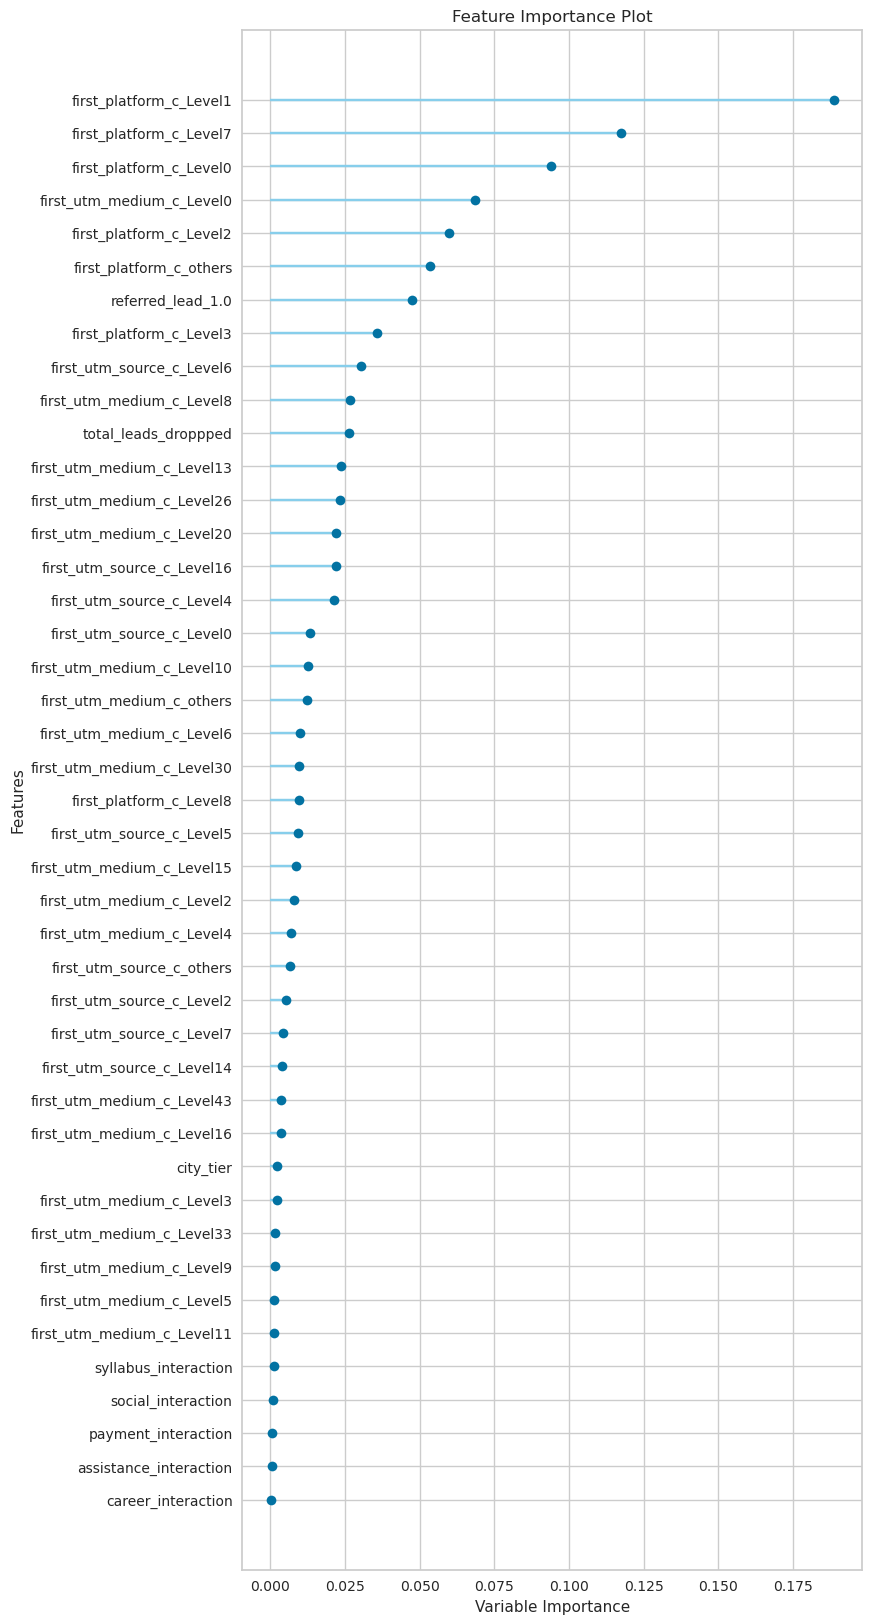

In [14]:
# create feature importance plot
plot_model(final_model, plot='feature_all')

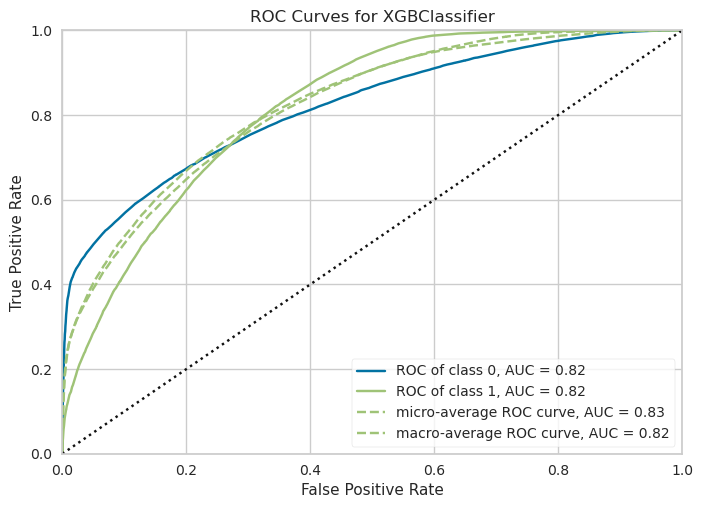

In [15]:
plot_model(final_model, plot = 'auc')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


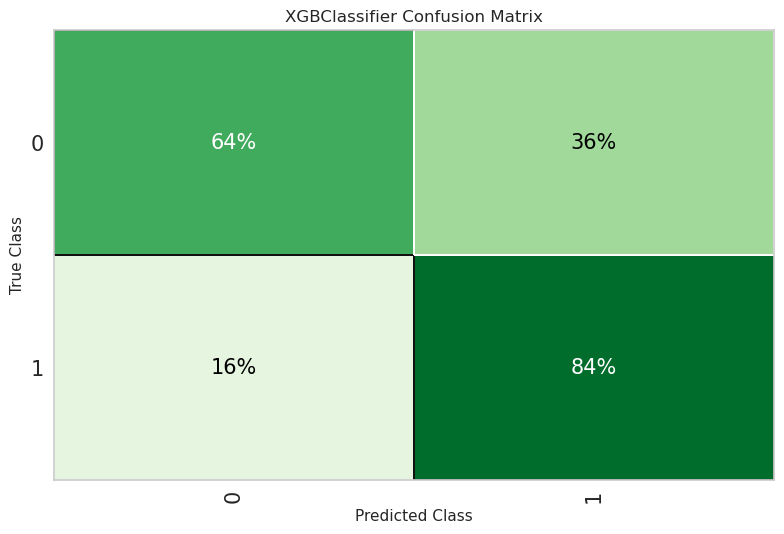

In [16]:
plot_model(final_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})


### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [17]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

In [18]:
significant_features = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 
                        'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
data = data[significant_features]

In [19]:
# Setup PyCaret with tree-based model settings
exp_tree = setup(
    data=data,
    target='app_complete_flag',
    fold_shuffle=True,
    session_id=42,
    normalize=False,
    transformation=False,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    n_jobs=4,
    use_gpu=False,
    experiment_name='Lead_Scoring_Model_Production',
    log_experiment=True,
    log_plots=True,
    log_data=True,
    verbose=True,
    log_profile=False,
    silent=True
)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 

In [21]:
best_tree_model = compare_models(sort='AUC', exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7384,0.8210,0.8333,0.7020,0.7621,0.4761,0.4848,0.1630
xgboost,Extreme Gradient Boosting,0.7380,0.8209,0.8312,0.7023,0.7613,0.4754,0.4837,1.8860
rf,Random Forest Classifier,0.7369,0.8187,0.8233,0.7037,0.7589,0.4733,0.4803,0.8000
et,Extra Trees Classifier,0.7364,0.8178,0.8204,0.7042,0.7579,0.4724,0.4790,0.9070
dt,Decision Tree Classifier,0.7362,0.8170,0.8201,0.7041,0.7576,0.4719,0.4785,0.1310
lr,Logistic Regression,0.7099,0.7834,0.8225,0.6731,0.7403,0.4190,0.4299,0.7400
lda,Linear Discriminant Analysis,0.7002,0.7725,0.7958,0.6699,0.7275,0.3997,0.4070,0.2470
nb,Naive Bayes,0.6694,0.7336,0.8577,0.6247,0.7229,0.3373,0.3640,0.0470
ridge,Ridge Classifier,0.7002,0.0000,0.7958,0.6699,0.7275,0.3997,0.4070,0.0490


In [22]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

In [23]:
lightgbm_model = create_model('lightgbm')

In [24]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

In [25]:
tuned_lightgbm = tune_model(lightgbm_model, optimize='AUC', fold=10, search_library='optuna')

In [26]:
# Print the final models configuration so that we can use it in the model retraining pipeline 

In [27]:
print(tuned_lightgbm)

LGBMClassifier(bagging_fraction=0.9954566116751746, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.9372941021749449, importance_type='split',
               learning_rate=0.320907017419298, max_depth=-1,
               min_child_samples=83, min_child_weight=0.001,
               min_split_gain=0.9238103658931417, n_estimators=31, n_jobs=4,
               num_leaves=229, objective=None, random_state=42,
               reg_alpha=1.0495042578329997e-09,
               reg_lambda=0.011371841870213657, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
